#INSTALLATION AND IMPORTS

In [ ]:
# GPU allowance
!pip install tensorflow-gpu
# Azure access api
!pip install azure-storage-blob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from azure.storage.blob import BlobServiceClient

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import pickle

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, concatenate, add
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.utils import plot_model
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam


#PRE PROCESS
* load data
* computer vision techniques
* data vizualisation

Loading data from azure database (Microsoft) to variables

In [ ]:
# establishing the connection
connect_str = 'DefaultEndpointsProtocol=https;AccountName=yaghmo;AccountKey=rYEvETXhJXd7+434KglSzII1CdWGU67ZxSmH0Tcretb8tNksyTO3Dxs0icWQwlV2WJjp8AaS0kbd+ASthREo3w==;EndpointSuffix=core.windows.net'
# Create a BlobServiceClient object to interact with the storage account
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

# Access the container (the stored database)
container_name = 'path'
container_client = blob_service_client.get_container_client(container_name)

Getting file names and sort them in case the dataset is not well sorted ( image + correspondence ) 

In [ ]:
id_images,id_masks=[],[]

# List the images inside the folder images
blobs = container_client.list_blobs(name_starts_with = 'COVID/images')
for blob in blobs:
  blob_client = container_client.get_blob_client(blob.name)
  id_images.append(blob.name)
id_images.sort()


# List the images inside the folder images
blobs = container_client.list_blobs(name_starts_with = 'COVID/masks')
for blob in blobs:
  blob_client = container_client.get_blob_client(blob.name)
  id_masks.append(blob.name)
id_masks.sort()

print("No. of images = ", len(id_images))
print("No. of masks = ", len(id_masks))

No. of images =  3616
No. of masks =  3616


These are still only the label path of the images, we need to split them here so we can save the test set to load it later once we have all our models trained, in a separate code

!!! PLEASE NOTICE !!! that we are keeping the same random state as the further split methode to ensure that the random shuffling of the data remains deterministic. which means the saved path label test set will remain same as its corresponding image test set

In [ ]:
# Split data into train and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(id_images, id_masks, test_size=0.1, random_state=42)


# Save the test path of images
df = pd.DataFrame({'images': X_test, 'masks': y_test})

model_name = 'FCNN'

# Write the DataFrame to a CSV file
df.to_csv(f'test_{model_name}.csv', index=False)
print('<====== A new file got created, please save it. it contains :',len(X_test),' lines.')

<====== A new file got created, please save it. it contains : 362  lines.


In [ ]:
df.sample(5)

,images,masks
167,COVID/images/COVID-2675.png,COVID/masks/COVID-2675.png
347,COVID/images/COVID-1371.png,COVID/masks/COVID-1371.png
50,COVID/images/COVID-1939.png,COVID/masks/COVID-1939.png
116,COVID/images/COVID-3419.png,COVID/masks/COVID-3419.png
63,COVID/images/COVID-2346.png,COVID/masks/COVID-2346.png


Load the images and their masks using their path from azure and applying some modifier as pre process

In [ ]:
# Setting some parameters
im_width = 256
im_height = 256

images = np.zeros(((len(id_images)), im_height, im_width), dtype=np.float32)
masks = np.zeros(((len(id_masks)), im_height, im_width), dtype=np.float32)


for i, file_name in tqdm_notebook(enumerate(id_images), total=len(id_images)):
    # Load images
    blob_client = container_client.get_blob_client(file_name)
    data = blob_client.download_blob().content_as_bytes()
    arr = np.frombuffer(data, np.uint8)
    img = cv2.imdecode(arr, cv2.IMREAD_GRAYSCALE)

    #pre process
    #Gaussian blur
    img = cv2.GaussianBlur(img,(3,3),cv2.BORDER_DEFAULT)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    #morpho gradient
    image = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    #egalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(image)
    img = resize(img_clahe, (im_width, im_height), mode='constant', preserve_range=True)
    images[i] = img/255


for i, file_name in tqdm_notebook(enumerate(id_masks), total=len(id_masks)):
    # Load images
    blob_client = container_client.get_blob_client(file_name)
    data = blob_client.download_blob().content_as_bytes()
    arr = np.frombuffer(data, np.uint8)
    img = cv2.imdecode(arr, cv2.IMREAD_GRAYSCALE)
    img = resize(img, (im_width, im_height), mode='constant', preserve_range=True)
    masks[i] = img/255



<ipython-input-19-deb8eca0b99c>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, file_name in tqdm_notebook(enumerate(id_images), total=len(id_images)):


  0%|          | 0/3616 [00:00<?, ?it/s]

<ipython-input-19-deb8eca0b99c>:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, file_name in tqdm_notebook(enumerate(id_masks), total=len(id_masks)):


  0%|          | 0/3616 [00:00<?, ?it/s]

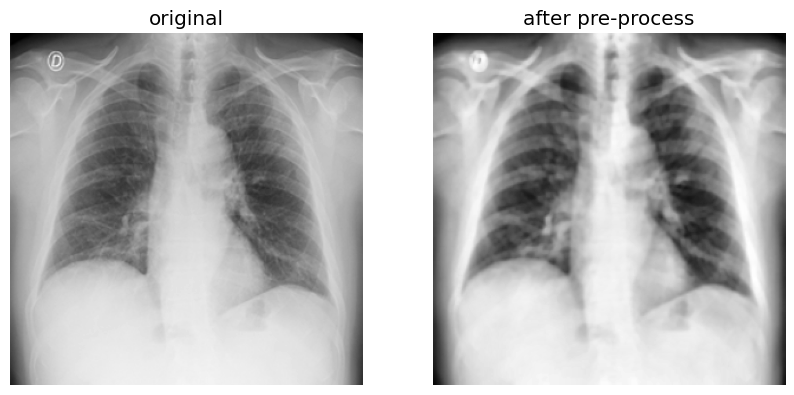

In [ ]:
# image sample
# Visualize a randome image without precocess and after
ix = random.randint(0, len(images)-1)

blob_client = container_client.get_blob_client(id_images[ix])
data = blob_client.download_blob().content_as_bytes()
arr = np.frombuffer(data, np.uint8)
img = cv2.imdecode(arr, cv2.IMREAD_GRAYSCALE)
fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].imshow(img,cmap='gray')
axes[1].imshow(images[ix]*255,cmap='gray')
axes[0].set_title('original')
axes[1].set_title('after pre-process')
axes[0].axis('off')
axes[1].axis('off')

plt.show()

In [ ]:
# Split data into train and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(images, masks, test_size=0.1, random_state=42)

# Split train data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)


Number of classes in the mask are : 1, ([0. 1.])


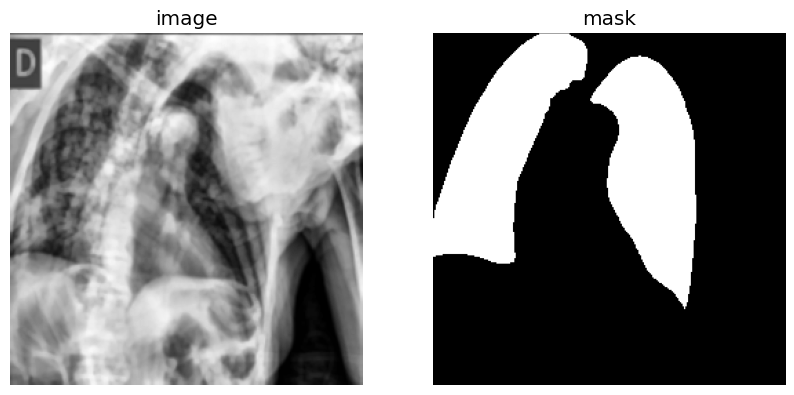

In [ ]:
# Visualize a randome image along with the mask
ix = random.randint(0, len(X_train)-1)

fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].imshow(X_train[ix]*255,cmap='gray')
axes[1].imshow(y_train[ix]*255,cmap='gray')
axes[0].set_title('image')
axes[1].set_title('mask')
axes[0].axis('off')
axes[1].axis('off')

print(f'Number of classes in the mask are : {len(np.unique(y_train[ix]))-1}, ({np.unique(y_train[ix])})')
plt.show()

#MODEL TRAINING
* FCNN

In [ ]:
def get_fcnn(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
  """Function to define the fcnn Model"""
  # feature extraction layers
  x = Conv2D(n_filters * 4, (3, 3), activation='relu', padding='same')(input_img)
  x = Conv2D(n_filters * 4, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Conv2D(n_filters * 8, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(n_filters * 8, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Conv2D(n_filters * 16, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(n_filters * 16, (3, 3), activation='relu', padding='same')(x)
  x = Conv2DTranspose(n_filters * 8, (2, 2), strides=(2, 2), padding='same', activation='relu')(x)
  x = Conv2D(n_filters * 8, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(n_filters * 8, (3, 3), activation='relu', padding='same')(x)
  x = Conv2DTranspose(n_filters * 4, (2, 2), strides=(2, 2), padding='same', activation='relu')(x)
  x = Conv2D(n_filters * 4, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(n_filters * 4, (3, 3), activation='relu', padding='same')(x)
  outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

  model = Model(inputs=[input_img], outputs=[outputs])
  return model

In [ ]:
input_img = Input((im_height, im_width,1))
model = get_fcnn(input_img, n_filters=4, dropout=0.1, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      9248      
                                                             

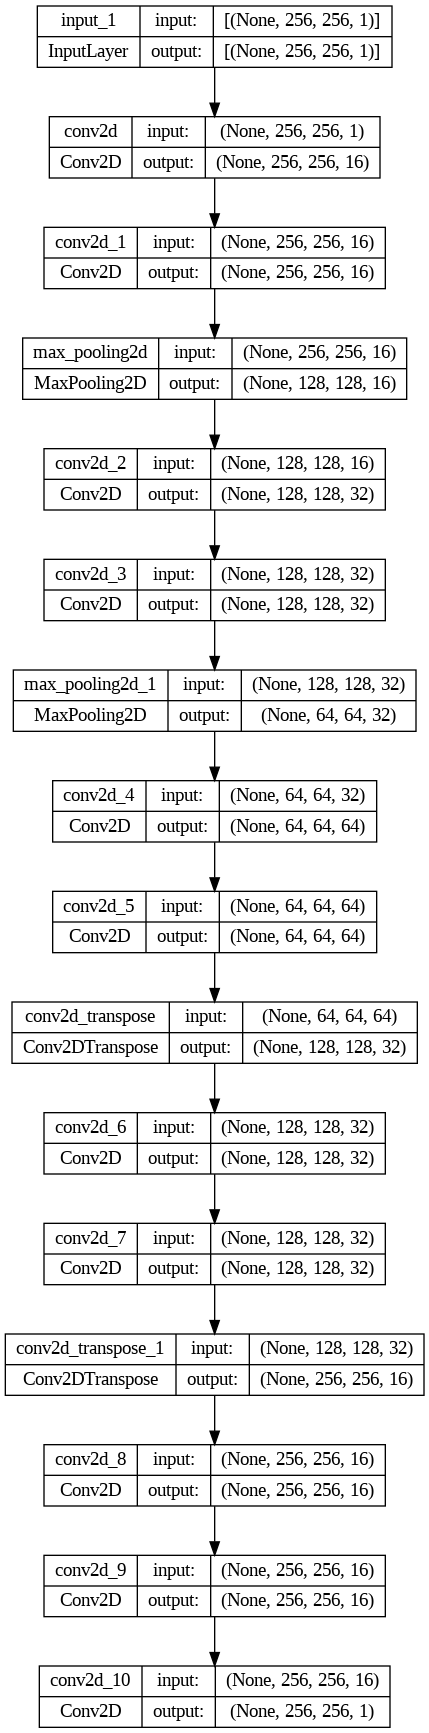

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
callbacks = [
    # EarlyStopping(patience=15, verbose=1),
    ReduceLROnPlateau(factor=0.05, patience=15, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-FCNN.h5', verbose=1, mode='max', monitor='val_accuracy', save_best_only=True, save_weights_only=False)
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=128, epochs=50, callbacks=callbacks, validation_data=(X_valid, y_valid))

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 0.6055 - accuracy: 0.7431
Epoch 1: val_accuracy improved from -inf to 0.75641, saving model to model-FCNN.h5
21/21 [==============================] - 39s 942ms/step - loss: 0.6055 - accuracy: 0.7431 - val_loss: 0.5356 - val_accuracy: 0.7564 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 0.5253 - accuracy: 0.7549
Epoch 2: val_accuracy did not improve from 0.75641
21/21 [==============================] - 14s 677ms/step - loss: 0.5253 - accuracy: 0.7549 - val_loss: 0.4939 - val_accuracy: 0.7564 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.4628 - accuracy: 0.7549
Epoch 3: val_accuracy did not improve from 0.75641
21/21 [==============================] - 14s 688ms/step - loss: 0.4628 - accuracy: 0.7549 - val_loss: 0.3990 - val_accuracy: 0.7564 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - ETA: 0s - loss: 0.3802 - accuracy: 0.7562
Epoc

In [ ]:
with open('results_FCNN.pkl', 'wb') as f:
  pickle.dump(results.history, f)

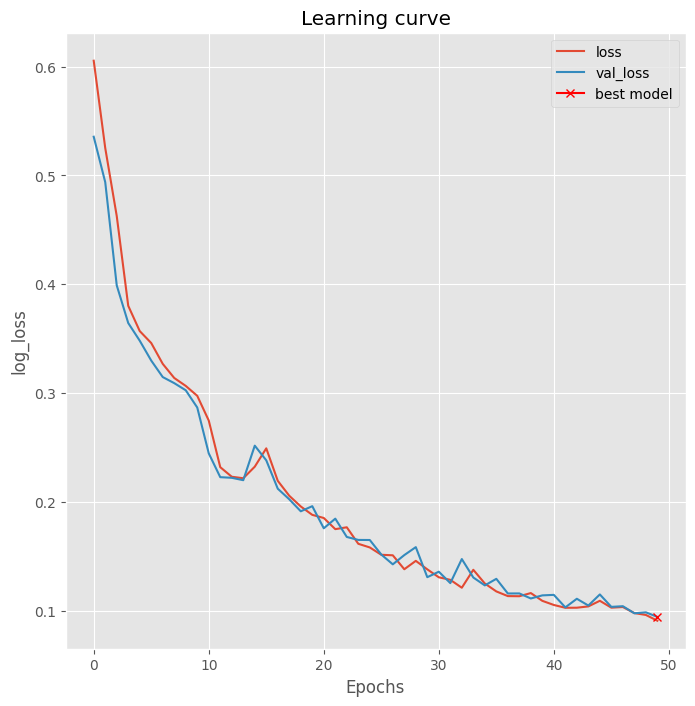

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

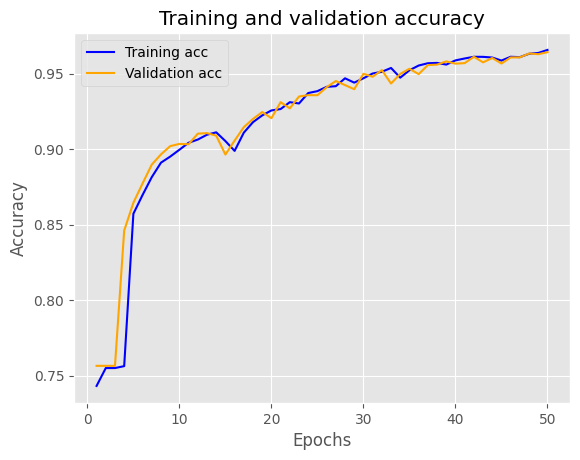

In [ ]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
epochs_model = range(1, len(acc)+1) 

plt.plot(epochs_model, acc, 'b', label = 'Training acc')
plt.plot(epochs_model, val_acc, 'orange', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
# load the best model
model.load_weights('model-FCNN.h5')
results = model.history

In [ ]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

# evaluate the model on the test data
loss, acc = model.evaluate(X_test, y_test)
val_loss, val_acc = model.evaluate(X_valid, y_valid)

print(f' train loss : {round(loss,4)} , train acc : {round(acc,4)}')
print(f' valid loss : {round(val_loss,4)} , valid acc : {round(val_acc,4)}')

21/21 [==============================] - 1s 46ms/step - loss: 0.0943 - accuracy: 0.9641
 train loss : 0.0877 , train acc : 0.9672
 valid loss : 0.0943 , valid acc : 0.9641


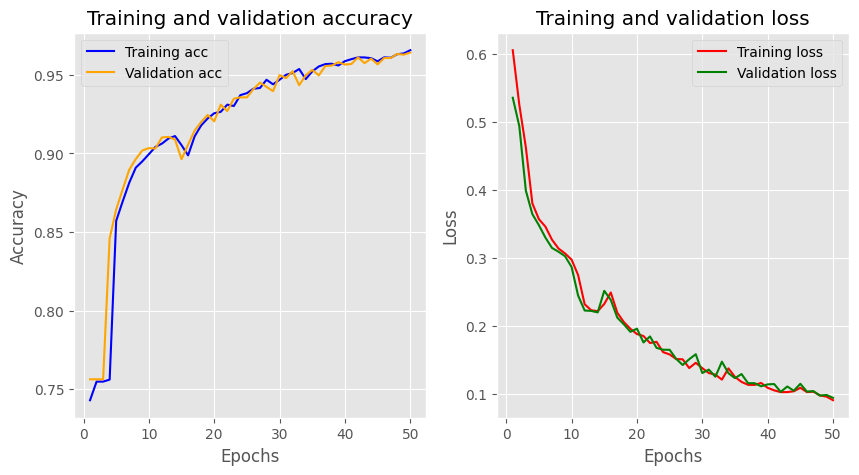

In [ ]:
# accuracy of best model
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs_model = range(1, len(acc)+1) 

fig, axes = plt.subplots(1, 2,  figsize=(10,5))
axes[0].plot(epochs_model, acc, 'b', label = 'Training acc')
axes[0].plot(epochs_model, val_acc, 'orange', label = 'Validation acc')
axes[0].set_title('Training and validation accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='best')

axes[1].plot(epochs_model, loss, 'r', label = 'Training loss')
axes[1].plot(epochs_model, val_loss, 'g', label = 'Validation loss')
axes[1].set_title('Training and validation loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='best')
plt.show()


#POST PROCESS
* treshold
* union
* metrics/evaluation vizualisation

In [ ]:
# Predict on train, val and test
preds = model.predict(X_test, verbose=1)
preds_test = model.predict(X_test, verbose=1)
preds_test2 = model.predict(X_test, verbose=1)
preds_test3 = model.predict(X_test, verbose=1)

12/12 [==============================] - 1s 37ms/step


In [ ]:
#treshold the results
preds_test[:][preds_test[:] < np.mean(preds_test[:])] = 0
preds_test[:][preds_test[:] >= np.mean(preds_test[:])] = 1

for i in range(len(preds_test2)):
  preds_test2[i][preds_test2[i] < np.mean(preds_test2[i])] = 0
  preds_test2[i][preds_test2[i] >= np.mean(preds_test2[i])] = 1

for i in range(len(preds_test3)):
  preds_test3[i] = preds_test[i] + preds_test2[i] 
  preds_test3[i][preds_test3[i] >= 1] = 1

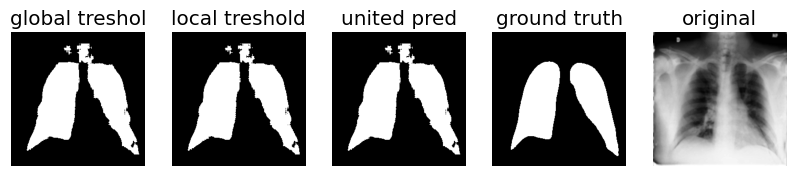

In [ ]:
#random visualization of the result along with mask and original image
ix = random.randint(0, len(X_test)-1)

fig, axes = plt.subplots(1, 5,  figsize=(10,5))

axes[0].imshow(preds_test[ix]*255,cmap='gray')
axes[1].imshow(preds_test2[ix]*255,cmap='gray')
axes[2].imshow(preds_test3[ix]*255,cmap='gray')
axes[3].imshow(y_test[ix]*255,cmap='gray')
axes[4].imshow(X_test[ix]*255,cmap='gray')
axes[0].set_title('global treshol')
axes[1].set_title('local treshold')
axes[2].set_title('united pred')
axes[3].set_title('ground truth')
axes[4].set_title('original')

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[3].axis('off')
axes[4].axis('off')
# Show the figure
plt.show()

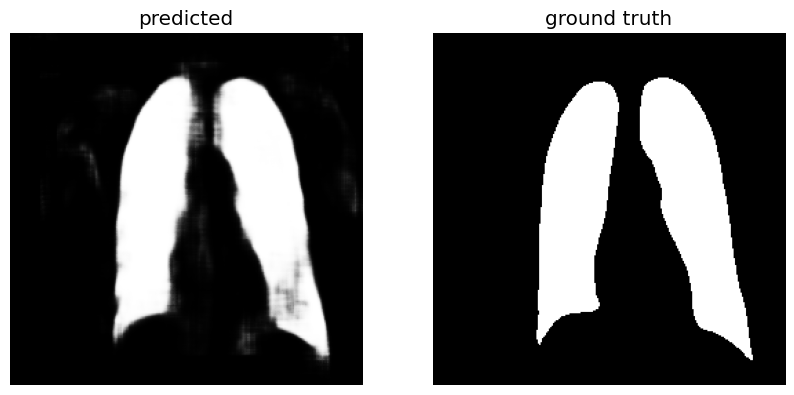

In [ ]:
#Example of predicted with no post process and mask
ix = random.randint(0, len(X_test)-1)

fig, axes = plt.subplots(1, 2,  figsize=(10,5))

axes[0].imshow(preds[ix]*255,cmap='gray')
axes[1].imshow(y_test[ix]*255,cmap='gray')
axes[0].set_title('predicted')
axes[1].set_title('ground truth')

axes[0].axis('off')
axes[1].axis('off')

plt.show()

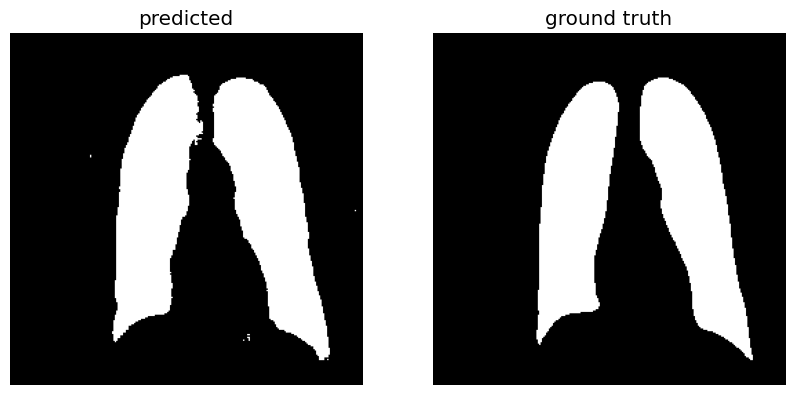

In [ ]:
#Example of predicted with final step of preprocess process and mask
fig, axes = plt.subplots(1, 2,  figsize=(10,5))

axes[0].imshow(preds_test3[ix]*255,cmap='gray')
axes[1].imshow(y_test[ix]*255,cmap='gray')
axes[0].set_title('predicted')
axes[1].set_title('ground truth')

axes[0].axis('off')
axes[1].axis('off')

plt.show()

Some various metrics to see the efficience

In [ ]:
def iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def dice_coef(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    dice_score = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice_score


In [ ]:
iou_scores = []
dice_scores = []
mse = []
preds_test = preds_test3.reshape(len(df), 256, 256)

for i in range(len(y_test)):
    iou_scores.append(iou(y_test[i], preds_test[i]))
    dice_scores.append(dice_coef(y_test[i], preds_test[i]))
    mse.append(mean_squared_error(y_test[i], preds_test[i]))

mean_iou = np.mean(iou_scores)
mean_dice = np.mean(dice_scores)
mse = np.mean(mse)

print('*'*21)
print(f'*  mean dice * {mean_dice.round(2)} *')
print('*'*21)
print(f'*  mean iou  * {mean_iou.round(2)} *')
print('*'*21)
print("*     MSE    * {:.2f}  *".format(mse.round(2)))
print('*'*21)

*********************
*  mean dice * 0.92 *
*********************
*  mean iou  * 0.86 *
*********************
*     MSE    * 0.04  *
*********************


Mean Intersection over Union: 0.08387523034169997


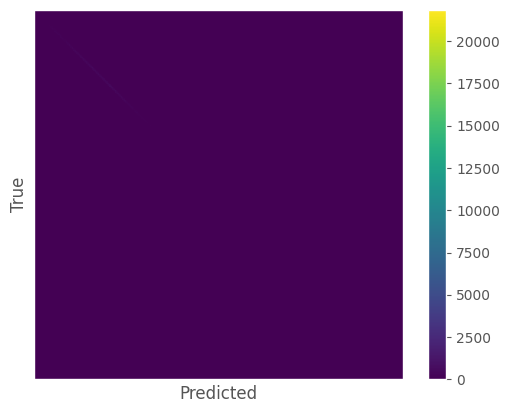

In [ ]:
# Convert the predicted masks and ground truth masks to binary
pred_masks_binary = np.argmax(preds_test, axis=-1)
test_masks_binary = np.argmax(y_test, axis=-1)

# Calculate the confusion matrix
cm = confusion_matrix(test_masks_binary.flatten(), pred_masks_binary.flatten())

#another way to get the miou
iou = np.diag(cm) / (np.sum(cm, axis=1) + np.sum(cm, axis=0) - np.diag(cm))
miou = np.mean(iou)

print('Mean Intersection over Union:', miou)
plt.imshow(cm, cmap=None)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()